# in this noteboook we look at the "spatial" variation of hp. i.e. the value of hp (or amp or phase) at a particular time across mass-ratio and chi


## findings

 - near merger h_plus is highly variable. this is difficult to fit
 - the amplitude is much smoother
 
I think this is the reason why it has been difficult to include the physical parameters so far


mild gaussian scale (=0.3) helps with a factor of 2 speed up in training over relu-only

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [5]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, chi=0, approximant="SEOBNRv4_opt", distance_mpc=1, return_time=None):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1z=chi,
        spin2z=chi,
        approximant=approximant,
        f_lower=8,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]
    
    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    if return_time is not None:
        # iy = IUS(new_times_M, hp)
        iy = IUS(new_times_M, new_amp)
        # iy = IUS(new_times_M, new_phase)
        return iy(return_time)
    else:
        return hp
    # return new_amp
    # return new_phase

In [6]:
mass_ratio = 4
# mass_ratio = 0.95
chi=0.99
total_mass = 100
approximant = "SEOBNRv4_opt"
# approximant = "SEOBNRv4P"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
t1 = -500
# t1 = -200
# t1 = -2000
# t1 = -5000
# t2 = 100
t2 = 70
dt = 0.5
# dt = 1
# dt = 0.25
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [7]:
new_times_M.shape


(1140,)

In [8]:
return_time=0

In [9]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, chi=chi, approximant=approximant, distance_mpc=distance_mpc,
                      return_time=return_time)

In [10]:
hp

array(0.13202429)

In [11]:
# qs = np.linspace(3, 5, 2)
qs = np.linspace(1,5,40)
# qs = np.array([1.])
# qs = np.arange(1, 1.2, 0.01)
# qs = np.arange(2, 3, 0.05)
chis = np.linspace(-0.99, 0.99, 40)
# chis = np.linspace(0.8, 0.99, 40)
# chis = np.linspace(0.8, 0.99, 2)
# chis = np.array([0.])
# chis = np.linspace(0., 0.5, 30)
# chis = np.linspace(0., 0.1, 5)
# chis = np.arange(0., 0.5, 0.01)
# chis = np.arange(-0.99, 0.99, 0.45)
# chis = np.arange(0.8, 0.9, 0.01)
# chis = np.arange(0.8, 0.99, 0.005)

# qs = np.linspace(1, 3, 5)
# chis = np.linspace(-0.99, 0.99, 5)


# chis = np.linspace(0.8, 0.99, 30)
# chis_1 = np.linspace(-0.99, 0.5, 10)
# chis_2 = np.linspace(0.5, 0.99, 10)
# chis = np.concatenate((chis_1, chis_2))

XX, YY = np.meshgrid(qs, chis)
XX = XX.ravel()
YY = YY.ravel()

In [12]:
test_chi_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
test_chi_scaled = test_chi_scaler.fit_transform(chis[:,np.newaxis])[:,0]

In [13]:
1/(chis[1]-chis[0])

19.69696969696969

In [14]:
1/(test_chi_scaled[1]-test_chi_scaled[0])

39.00000000000006

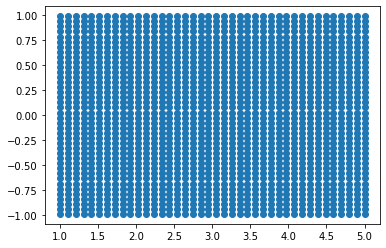

In [15]:
plt.scatter(XX, YY)

In [16]:
num_samples = len(XX)

In [17]:
num_samples

1600

In [18]:
%%time
hps = []
for i in range(num_samples):
    mass_ratio = XX[i]
    chi = YY[i]
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, chi=chi, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc,
                          return_time=return_time)
    hps.append(hp)
hps = np.array(hps)

CPU times: user 33.1 s, sys: 2.03 s, total: 35.1 s
Wall time: 35.3 s


In [19]:
hps.shape

(1600,)

In [20]:
theta = np.column_stack((XX, YY))

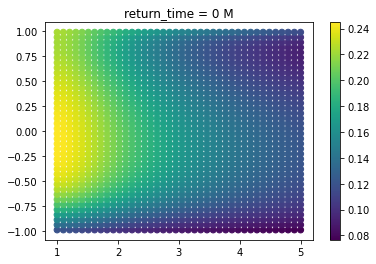

In [21]:
plt.figure()
plt.scatter(theta[:,0], theta[:,1], c=hps)
plt.title(f"return_time = {return_time} M")
plt.colorbar()

Text(0.5, 0.92, 'return_time = 0 M')

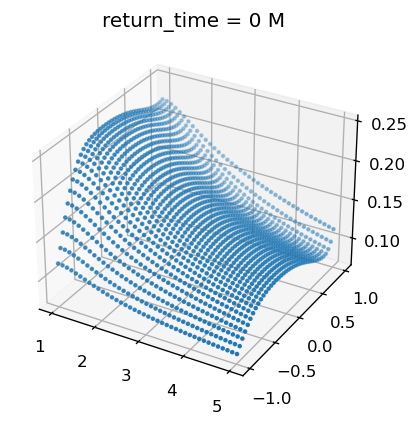

In [22]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(theta[:,0], theta[:,1], hps, s=3)
plt.title(f"return_time = {return_time} M")

In [23]:
theta_idxs = np.arange(len(theta))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
theta_training_idxs = theta_idxs[::2]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
theta_training_idxs = np.concatenate((theta_training_idxs, [theta_idxs[-1]]))
theta_validation_idxs = theta_idxs[1:-1:2] 

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# theta_training_idxs = theta_idxs
# theta_validation_idxs = theta_idxs

In [24]:
theta_training_idxs

array([   0,    2,    4,    6,    8,   10,   12,   14,   16,   18,   20,
         22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
         44,   46,   48,   50,   52,   54,   56,   58,   60,   62,   64,
         66,   68,   70,   72,   74,   76,   78,   80,   82,   84,   86,
         88,   90,   92,   94,   96,   98,  100,  102,  104,  106,  108,
        110,  112,  114,  116,  118,  120,  122,  124,  126,  128,  130,
        132,  134,  136,  138,  140,  142,  144,  146,  148,  150,  152,
        154,  156,  158,  160,  162,  164,  166,  168,  170,  172,  174,
        176,  178,  180,  182,  184,  186,  188,  190,  192,  194,  196,
        198,  200,  202,  204,  206,  208,  210,  212,  214,  216,  218,
        220,  222,  224,  226,  228,  230,  232,  234,  236,  238,  240,
        242,  244,  246,  248,  250,  252,  254,  256,  258,  260,  262,
        264,  266,  268,  270,  272,  274,  276,  278,  280,  282,  284,
        286,  288,  290,  292,  294,  296,  298,  3

In [25]:
theta_validation_idxs

array([   1,    3,    5,    7,    9,   11,   13,   15,   17,   19,   21,
         23,   25,   27,   29,   31,   33,   35,   37,   39,   41,   43,
         45,   47,   49,   51,   53,   55,   57,   59,   61,   63,   65,
         67,   69,   71,   73,   75,   77,   79,   81,   83,   85,   87,
         89,   91,   93,   95,   97,   99,  101,  103,  105,  107,  109,
        111,  113,  115,  117,  119,  121,  123,  125,  127,  129,  131,
        133,  135,  137,  139,  141,  143,  145,  147,  149,  151,  153,
        155,  157,  159,  161,  163,  165,  167,  169,  171,  173,  175,
        177,  179,  181,  183,  185,  187,  189,  191,  193,  195,  197,
        199,  201,  203,  205,  207,  209,  211,  213,  215,  217,  219,
        221,  223,  225,  227,  229,  231,  233,  235,  237,  239,  241,
        243,  245,  247,  249,  251,  253,  255,  257,  259,  261,  263,
        265,  267,  269,  271,  273,  275,  277,  279,  281,  283,  285,
        287,  289,  291,  293,  295,  297,  299,  3

In [26]:
len(theta_idxs)

1600

In [27]:

len(theta_training_idxs)


801

In [28]:

len(theta_validation_idxs)

799

In [29]:
theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
theta_scaled = theta_scaler.fit_transform(theta)
# theta_scaled = theta_scaler.fit_transform(theta_1_scaled)

In [30]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [31]:
X_training = theta_scaled[theta_training_idxs]

In [32]:
X_validation = theta_scaled[theta_validation_idxs]

In [33]:
X_training.shape

(801, 2)

In [34]:
X_validation.shape

(799, 2)

In [35]:
hps.shape

(1600,)

In [36]:
# y_training = hps[np.ix_(theta_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(theta_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[theta_training_idxs]
y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[theta_validation_idxs]
y_validation = y_validation.reshape(-1, 1)

In [37]:
y_training.shape

(801, 1)

In [38]:
y_validation.shape

(799, 1)

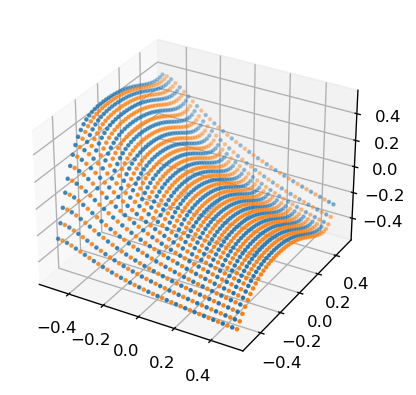

In [39]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,1], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,1], y_validation, s=3)

In [70]:
def run_simple_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1", validation_batch_size=None):
    activation = 'relu'
    # units = 256
    units = 64
    # units = 512
    # units = 1024
    n_layers = 3
    # n_layers = 6
    gaussian_projection = 16
    # gaussian_scale = 64/4/8
    
    gaussian_scale = 0.3
    # gaussian_scale = 0.1


    inputs = tf.keras.Input(shape=(2,))
    x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(inputs)
    # x = tf.keras.layers.Dense(units, activation)(inputs)
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.5, monitor='loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    print(model.summary())

    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, validation_batch_size=validation_batch_size)
    
    return history, model

In [71]:
X_training.shape

(801, 2)

In [72]:
len(X_training)//5

160

In [73]:
epochs=200
# epochs=2000
# batch_size = 32
# batch_size = 128
batch_size = 512
# batch_size = 1024
# batch_size = 2048
# batch_size = 4096
# batch_size = 8192
# batch_size = 130560
# batch_size = len(X_training)//5
# batch_size = len(X_training)//20

# validation_batch_size=8192
validation_batch_size=None
print(batch_size)

# learning_rate = 1e-2
learning_rate = 1e-3
# learning_rate = 1e-4
print(learning_rate)

512
0.001


In [74]:
%%time
history, model = run_simple_model(
    X_training,
    y_training,
    epochs=epochs,
    batch_size=batch_size,
    # validation_data=(X_validation, y_validation),
    validation_data=(X_validation, y_validation),
    # validation_data=None,
    learning_rate=learning_rate,
    threshold=4e-6,
    verbose=1,
    validation_batch_size=validation_batch_size,
    # threshold=3e-6
    )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 fourier_feature_projection_  (None, 32)               32        
 1 (FourierFeatureProjection                                     
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65  

2022-06-21 22:41:43.618974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 146ms/step - loss: 0.1613 - val_loss: 0.0773
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0717 - val_loss: 0.0426
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0395 - val_loss: 0.0151
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0146 - val_loss: 0.0112
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0123 - val_loss: 0.0157
Epoch 6/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0159

2022-06-21 22:41:43.822432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 25ms/step - loss: 0.0151 - val_loss: 0.0108
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0101 - val_loss: 0.0105
Epoch 9/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 10/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 11/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 12/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 13/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 14/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 15/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 16/200
2/2 [========

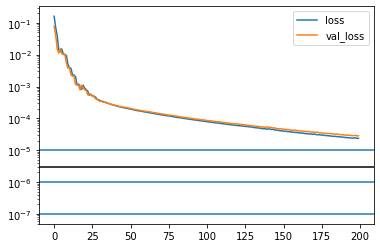

In [75]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")

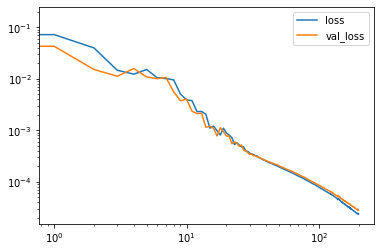

In [76]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [77]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

<Figure size 432x288 with 0 Axes>

In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 fourier_feature_projection_  (None, 32)               32        
 1 (FourierFeatureProjection                                     
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65  

In [79]:
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [80]:
# model.layers[1].weights[0]

In [81]:
# w=model.layers[1].weights[0].numpy()[0]
# plt.scatter(range(len(w)), w)

In [82]:
theta[theta_validation_idxs[-1]]

array([4.79487179, 0.99      ])

In [83]:
theta[theta_training_idxs[-1]]

array([5.  , 0.99])

In [84]:
theta_scaled[theta_training_idxs[-1]]

array([0.5, 0.5])

In [85]:
# test_input[np.newaxis,:].shape

In [86]:
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_training_idxs[-1]])

test_input=theta_scaled[theta_training_idxs[-1]]
test_yhat = model.predict(test_input[np.newaxis,:], verbose=0)

2022-06-21 22:41:51.853664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [99]:
test_input[np.newaxis,:].shape


(1, 2)

In [ ]:
# https://stackoverflow.com/questions/60159714/when-to-use-model-predictx-vs-modelx-in-tensorflow
# model.predict(x) vs model(x)

In [102]:
%%timeit
test_yhat = model.predict(test_input[np.newaxis,:], verbose=0)

20.8 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
%%timeit
test_yhat = model(test_input[np.newaxis,:])

2.96 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
test_input.shape

(2,)

In [89]:
test_yhat

array([[-0.26830357]], dtype=float32)

In [90]:
hps_scaled[theta_training_idxs[-1]]

-0.27023182782555477

In [91]:
yhat_training = model.predict(theta_scaled[theta_training_idxs], verbose=0)
yhat_val = model.predict(theta_scaled[theta_validation_idxs], verbose=0)

Text(0.5, 1.0, 'train')

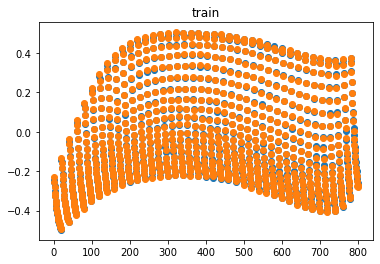

In [92]:
plt.figure()
plt.plot(y_training, 'o')
plt.plot(yhat_training, 'o')
plt.title('train')

Text(0.5, 1.0, 'train')

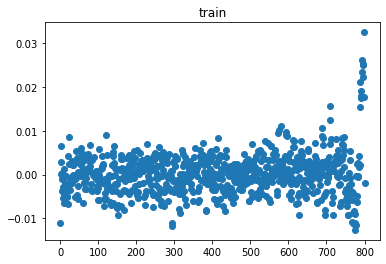

In [93]:
plt.figure()
plt.plot(y_training-yhat_training, 'o')
plt.title('train')

Text(0.5, 1.0, 'validaiton')

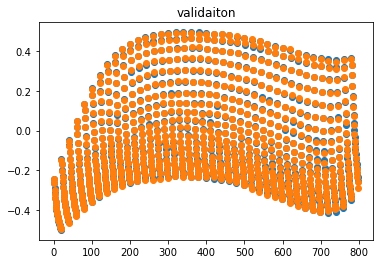

In [94]:
plt.figure()
plt.plot(y_validation, 'o')
plt.plot(yhat_val, 'o')
plt.title('validaiton')

Text(0.5, 1.0, 'validaiton')

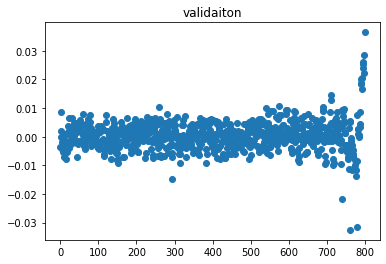

In [95]:
plt.figure()
plt.plot(y_validation-yhat_val, 'o')
plt.title('validaiton')

Text(0.5, 0.92, 'training')

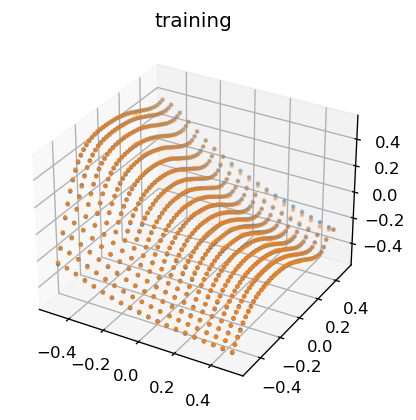

In [96]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,1], y_training, s=3)
ax.scatter(X_training[:,0], X_training[:,1], yhat_training, s=3)
plt.title('training')

Text(0.5, 0.92, 'val')

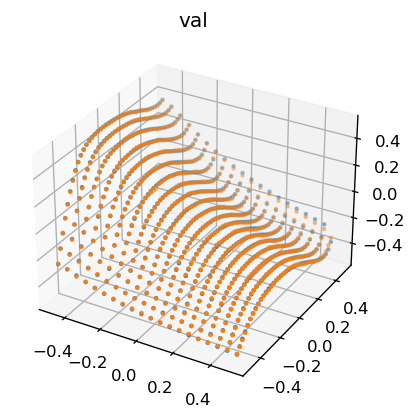

In [97]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_validation[:,0], X_validation[:,1], y_validation, s=3)
ax.scatter(X_validation[:,0], X_validation[:,1], yhat_val, s=3)
plt.title('val')

In [98]:
# %%timeit
# # model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

# model.predict([test_input[:,0], test_input[:,1], test_input[:,2]], verbose=0)